In [1]:
import json
import os
import numpy
import pandas
import sys
import logging
import importlib

from datetime import date
from os import path
from dotenv import load_dotenv

sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from bespoke.inventory.analysis.shared import download_util
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.inventory.analysis import inventory_cogs_util as cogs_util
from bespoke.inventory.analysis import inventory_summary_util
from bespoke.inventory.analysis import stale_inventory_util
from bespoke.inventory.analysis.shared.inventory_types import (
  AnalysisSummaryDict,
  FacilityDetailsDict,
  CompanyInfoDict
)

load_dotenv(verbose=True)
engine = download_util.get_bigquery_engine('bigquery://bespoke-financial/ProdMetrcData')

logging.basicConfig(format='%(asctime)s [%(levelname)s] - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

def _reload_libs():
    importlib.reload(util)
    importlib.reload(valuations_util)
    importlib.reload(download_util)
    importlib.reload(stale_inventory_util)

%load_ext autoreload
%autoreload 2

In [16]:
COMPANY_NAME = 'RA'
COMPANY_IDENTIFIER = 'RA'
LICENSE_NUMBERS = [] # ['MR281525'] # Manufacturer FYI - 'MP281397'
FACILITY_DETAILS = FacilityDetailsDict(
    license_numbers=LICENSE_NUMBERS,
    name='default',
    num_bad_download_summaries=0
)
TRANSFER_PACKAGES_START_DATE = '2019-01-01'
SALES_TRANSACTIONS_START_DATE = '2019-01-01'
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
    'use_prices_to_fill_missing_incoming': False,
    'external_pricing_data_config': {
        'category_to_fixed_prices': {
            'Buds': {
                'grams': 10.0
            },
            'Infused (edible)': {
                'each': 4.0
            },
            'Infused (non-edible)': {
                'each': 3.0
            },
            'Vape Product': {
                'each': 3.0
            },
            'Concentrate (Bulk)': {
                'grams': 6.0
            },
            'Concentrate': {
                'grams': 7.0
            },
            'Raw Pre-Rolls': {
                'grams': 7.0,
                'pounds': 80.0
            },
            'Shake/Trim (by strain)': {
                'grams': 8.0
            }
        }
    },
    'use_margin_estimate_config': False,
    'margin_estimate_config': {
        'category_to_margin_estimate': {
            'Buds': 0.4267,
            'Infused (edible)': 0.4953,
            'Infused (non-edible)': 0.4183,
            'Vape Product': 0.43,
            'Concentrate (Bulk)': 0.46,
            'Concentrate': 0.46,
            'Raw Pre-Rolls': 0.485,
            'Shake/Trim (by strain)': 0.4267
        }
    },
    'cogs_analysis_params': {
        'readjust_profit_threshold': 0.90, # 0.9
        'readjust_type': 'adjust' # adjust, remove
    },
    'stale_inventory_params': {
        'product_category_to_shelf_life': {
            "Flower": 6,
            "Trim": 6,
            "Fresh Frozen": 0,
            "Edibles": 6,
            "Wax": 12,
            "Resin": 12,
            "Tinctures": 12,
            "Vapes": 12,
            "Shatter": 12,
            "Concentrates": 12,
            "Rosin": 12,
            "Beverages": None,
            "unknown": 12           
        }
    }
}
TODAY_DATE = date.today()
print('Today is {}'.format(TODAY_DATE))

download_ctx = download_util.DataframeDownloadContext(
    output_root_dir=f'out/{COMPANY_NAME}',
    read_params={
        'use_cached_dataframes': False
    },
    write_params={
        'save_download_dataframes': False
    }
)
download_ctx.mkdir('download')

ctx = download_util.AnalysisContext(
    output_root_dir=f'out/{COMPANY_NAME}'
)
ctx.mkdir('reports')
with open(ctx.get_output_path('log.txt'), 'w') as f:
    f.write('')

Today is 2022-01-04


In [3]:
# Download packages, sales transactions, incoming / outgoing tranfers
df_query_params = download_util.DataFrameQueryParams(
    company_identifier=COMPANY_IDENTIFIER,
    transfer_packages_start_date=TRANSFER_PACKAGES_START_DATE,
    sales_transactions_start_date=SALES_TRANSACTIONS_START_DATE,
    license_numbers=LICENSE_NUMBERS
)
sql_helper = download_util.BigQuerySQLHelper(download_ctx, engine)
all_dataframes_dict = download_util.get_dataframes_for_analysis(
    df_query_params, download_ctx, sql_helper, dry_run=False, num_threads=2, use_incremental_querying=False)

In [4]:
_reload_libs()

q = download_util.Query(
    inventory_dates=download_util.get_inventory_dates(
      all_dataframes_dict, TODAY_DATE),
    company_id='',
    company_name=COMPANY_NAME,
    company_identifier=COMPANY_IDENTIFIER,
)
d = util.Download()
d.process_dataframes(
    all_dataframes_dict=all_dataframes_dict,
    ctx=ctx
)

01/04/2022 14:23:31 [INFO] - Processing 6389 incoming transfer packages
01/04/2022 14:23:31 [INFO] - Processing 99 outgoing transfer packages
01/04/2022 14:23:31 [INFO] - Processing 6124 inventory packages
01/04/2022 14:23:31 [INFO] - Processing 60681 sales receipts
01/04/2022 14:23:31 [INFO] - Processing 167783 sales transactions
01/04/2022 14:23:33 [INFO] -   Took 2.55 seconds for converting to records
01/04/2022 14:23:34 [INFO] -   Took 0.15 seconds to iterate through sales txs
01/04/2022 14:23:34 [INFO] -   Took 0.08 seconds to iterate through incoming records
01/04/2022 14:23:34 [INFO] -   Took 0.0 seconds to iterate through outgoing records
01/04/2022 14:23:34 [INFO] -   Took 0.0 seconds to iterate through rest of records


In [7]:
_reload_libs()

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(ctx, id_to_history)
compute_inventory_dict = util.create_inventory_xlsx(
    d, ctx, id_to_history, q, params=ANALYSIS_PARAMS, using_nb=True)

Only outgoing: 7
Only incoming: 1648
Sold packages missing incoming_pkg: 0 (0.00% of packages)
Incoming packages missing price 130 (2.05% of incoming packages)
In and out: 92
In and sold at least once 4661
In and sold many times 4458

 Num parent packages: 0
 num matched child packages: 0
Total pkgs: 6356


01/04/2022 14:31:02 [INFO] -   Took 0.86 seconds for computing additional fields. num_loops=6356
01/04/2022 14:31:02 [INFO] - On 02/29/2020 # packages in inventory: 46, valuation cost: 2502.0
01/04/2022 14:31:02 [INFO] - On 03/31/2020 # packages in inventory: 188, valuation cost: 30369.67
01/04/2022 14:31:02 [INFO] - On 04/30/2020 # packages in inventory: 502, valuation cost: 56850.48
01/04/2022 14:31:02 [INFO] - On 05/31/2020 # packages in inventory: 671, valuation cost: 51227.99
01/04/2022 14:31:03 [INFO] - On 06/30/2020 # packages in inventory: 855, valuation cost: 58306.96
01/04/2022 14:31:03 [INFO] - On 07/31/2020 # packages in inventory: 1018, valuation cost: 75605.65
01/04/2022 14:31:03 [INFO] - On 08/31/2020 # packages in inventory: 1250, valuation cost: 110632.0
01/04/2022 14:31:04 [INFO] - On 09/30/2020 # packages in inventory: 1457, valuation cost: 145846.99
01/04/2022 14:31:04 [INFO] - On 10/31/2020 # packages in inventory: 1712, valuation cost: 181638.87
01/04/2022 14:31:0



Excluded 190 / 6356 packages from consideration (2.99%)
  OUT_OF_ORDER_DATES: 32 times
  INCOMING_MISSING_PRICE: 151 times
  MISSING_INCOMING: 7 times


In [8]:
_reload_libs()

today_date_str = TODAY_DATE.strftime('%m/%d/%Y')
#INVENTORY_DATES = [today_date_str]
compare_inventory_res = util.compare_computed_vs_actual_inventory(
    ctx=ctx,
    computed=compute_inventory_dict['date_to_computed_inventory_dataframe'][today_date_str],
    actual=d.inventory_packages_dataframe,
    params=ANALYSIS_PARAMS,
    compare_options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    },
    today=TODAY_DATE
)




Pct of # inventory matching: 97.73% (3969 / 4061)
Accuracy of quantities for matching packages: 98.77%
Pct of # inventory packages over-estimated: 3.37%
Pct of # quantity over-estimated: 0.06%
Avg quantity delta of matching packages: 0.06
Avg quantity of matching packages: 5.01

Num matching packages: 3969
Num actual packages not computed: 92
  but computed at some point: 0, e.g., 0.00% of non-computed packages
  avg quantity from actual packages 0.00
Num computed packages not in actual: 137
  but in actual inventory at some point: 101

Computed has these extra package IDs; first 10
3576925: computed quantity 98.0 (Grams)
12664646: computed quantity 92.0 (Each)
3578093: computed quantity 84.0 (Grams)
17562729: computed quantity 64.0 (Each)
17481959: computed quantity 40.0 (Each)
3576931: computed quantity 38.5 (Grams)
5262621: computed quantity 38.0 (Each)
10190898: computed quantity 32.0 (Each)
3576934: computed quantity 31.5 (Grams)
3455285: computed quantity 30.0 (Each)
3497652: c

In [14]:
## Inventory valuations
date_and_computed_valuation = list(zip(q.inventory_dates, compute_inventory_dict['inventory_valuations']))[-1]

print('Cost valuation based on computed inventory as of {} is ${}'.format(
  date_and_computed_valuation[0], round(date_and_computed_valuation[1], 2)
))

print('')
inventory_cost_valuation_res = valuations_util.get_inventory_valuation(
    inventory_packages_dataframe=d.inventory_packages_dataframe,
    incoming_transfer_packages_dataframe=d.incoming_transfer_packages_dataframe,
    params=ANALYSIS_PARAMS,
    today=TODAY_DATE
)
print(f'Cost valuation of Metrc-reported inventory as of today: ${round(inventory_cost_valuation_res["total_valuation"], 2)}')

Cost valuation based on computed inventory as of 01/04/2022 is $167070.53

Cost valuation of Metrc-reported inventory as of today: $158360.11


In [17]:
_reload_libs()

# Do the COGS summary too
#  debug_package_id='1791802',
#  debug_profit_threshold=0.9

cogs_summary = cogs_util.create_cogs_summary(
    d, ctx, id_to_history, ANALYSIS_PARAMS, 
)

cogs_util.write_cogs_xlsx(
    ctx=ctx,
    topdown_cogs_rows=cogs_summary['topdown_cogs_rows'], 
    bottoms_up_cogs_rows=cogs_summary['bottomsup_cogs_rows'],
    company_name=COMPANY_NAME
)

analysis_summary = AnalysisSummaryDict(
    company_info=CompanyInfoDict(
      company_name=q.company_name,
      company_identifier=q.company_identifier,
      company_id='',
      index=0
    ),
    facility_details=FACILITY_DETAILS,
    analysis_params=ANALYSIS_PARAMS,
    counts_analysis=compute_inventory_dict['counts_analysis'],
    compare_inventory_results=compare_inventory_res,
    cogs_summary=cogs_summary
)
inventory_summary_util.write_excel_for_summaries([analysis_summary], TODAY_DATE)

01/04/2022 14:36:06 [INFO] - Wrote result to out/RA/reports/RA_cogs_summary.xls
01/04/2022 14:36:06 [INFO] - Wrote result to out/RA_analysis_summary.xls


In [18]:
# Stale inventory

_reload_libs()
stale_inventory_util.compute_stale_inventory(d, ctx, ANALYSIS_PARAMS, today=TODAY_DATE)

Got an invalid quantity Product Flower (packaged ounce - each) -1.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Immature Plant 0.0
Got an unexpected package type ImmaturePlant Immature Plant 24.0
Got an unexpected package type ImmaturePlant Clone - Cutting -6.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 1.0
Got an unexpected package type ImmaturePlant Clone - Cutting 6.0
Got an unexpected package type ImmaturePlant Clone - Cutting 8.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 1.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected pack

/Users/davidlluncor/GitHub/platform/services/api-server/src/bespoke/inventory/analysis/stale_inventory_util.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (d.incoming_transfer_packages_dataframe['shipper_wholesale_price'] != 0.01) | (d.incoming_transfer_packages_dataframe['shipped_quantity'] != 1)


Plotting sales revenue vs cost-based inventory valuation for dates: ['02/29/2020', '03/31/2020', '04/30/2020', '05/31/2020', '06/30/2020', '07/31/2020', '08/31/2020', '09/30/2020', '10/31/2020', '11/30/2020', '12/31/2020', '01/31/2021', '02/28/2021', '03/31/2021', '04/30/2021', '05/31/2021', '06/30/2021', '07/31/2021', '08/31/2021', '09/30/2021', '10/31/2021', '11/30/2021', '12/31/2021', '01/04/2022']


01/04/2022 14:36:58 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
01/04/2022 14:36:58 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
01/04/2022 14:36:58 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
01/04/2022 14:36:58 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
01/04/2022 14:36:58 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

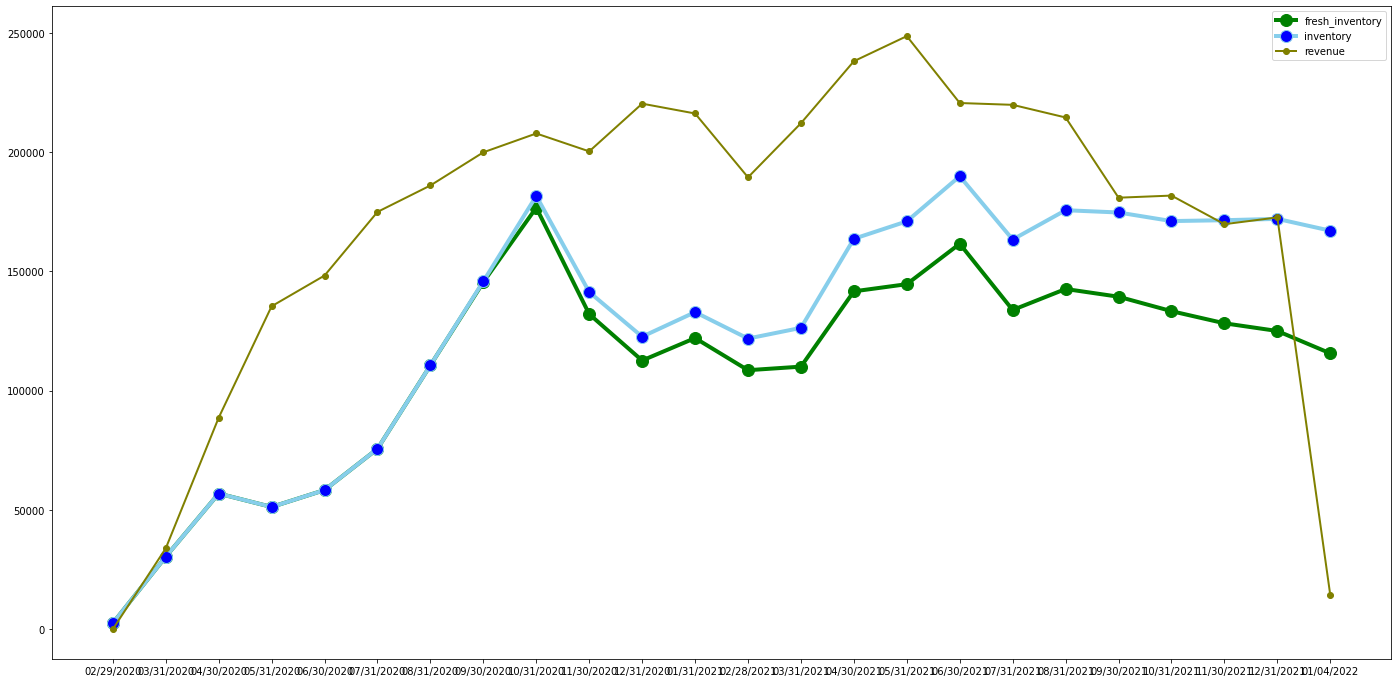

In [19]:
_reload_libs()

print(f'Plotting sales revenue vs cost-based inventory valuation for dates: {q.inventory_dates}')
valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=compute_inventory_dict['inventory_valuations'],
    fresh_inventory_valuations=compute_inventory_dict['fresh_inventory_valuations']
)

In [ ]:
## DEBUG
util.run_orphan_analysis(d, ctx, id_to_history)

In [96]:
# For debugging individual package histories
_reload_libs()

PACKAGE_IDS = [
  '767702'
]

util.analyze_specific_package_histories(
    d, PACKAGE_IDS, params=ANALYSIS_PARAMS)

11/16/2021 11:05:32 [INFO] - 
Package 767702 arrived on 07/14/2020 with quantity 47.0 and price $30.0.
Package 767702 sold on 08/15/2020 1.0 (Each) for $65.0
Package 767702 sold on 12/03/2020 1.0 (Each) for $60.0
Package 767702 sold on 12/07/2020 1.0 (Each) for $60.0
Package 767702 sold on 01/02/2021 3.0 (Each) for $180.0
Package 767702 sold on 01/04/2021 1.0 (Each) for $60.0
Package 767702 sold on 01/21/2021 2.0 (Each) for $120.0
Package 767702 sold on 01/28/2021 1.0 (Each) for $60.0
Package 767702 sold on 02/28/2021 1.0 (Each) for $60.0
Package 767702 sold on 03/16/2021 1.0 (Each) for $55.0
Package 767702 sold on 03/22/2021 1.0 (Each) for $55.0
Package 767702 sold on 04/03/2021 1.0 (Each) for $55.0
Package 767702 sold on 05/29/2021 1.0 (Each) for $55.0
Package 767702 sold on 06/11/2021 1.0 (Each) for $55.0
Package 767702 sold on 06/23/2021 1.0 (Each) for $50.0
Package 767702 sold on 07/06/2021 1.0 (Each) for $45.0
Package 767702 sold on 07/11/2021 1.0 (Each) for $45.0
Package 767702 

DEBUGGING PACKAGE_ID=767702
Matching active metrc_package:
{'license_number': 'MR281525', 'package_id': '767702', 'package_label': '1A40A01000010CD000010718', 'type': 'active', 'packaged_date': datetime.date(2020, 7, 14), 'last_modified_at': Timestamp('2021-11-16 01:02:42+0000', tz='UTC'), 'package_type': 'Product', 'product_name': 'M00000249805: Vape Rythm Heal PAX Pod Otto 1:1 Concentrate', 'product_category_name': 'Vape Product', 'quantity': 5.0, 'unit_of_measure': 'Each', 'item_id': 249805, 'item_product_category_type': 'Concentrate', 'production_batch_number': '', 'source_production_batch_numbers': '', 'source_harvest_names': '', 'is_testing_sample': False, 'is_trade_sample': False, 'is_on_hold': False, 'archived_date': None, 'finished_date': None}

INCOMING
{'delivery_type': 'INCOMING_FROM_VENDOR', 'license_number': 'MR281525', 'manifest_number': '0000170521', 'created_date': datetime.date(2020, 7, 14), 'received_datetime': datetime.datetime(2020, 7, 14, 23, 32, 25, tzinfo=<UTC>)